# Using Orfeo Tool Box from Python

reference: https://www.orfeo-toolbox.org/CookBook/PythonAPI.html#numpy-array-processing

In [1]:
from pyproj.enums import WktVersion
from typing import Union, Optional
import geopandas as gpd
import numpy as np
import os
import gdal
import otbApplication as otb
import pyproj
import rasterio
import rasterio.plot
import sys

from mantle_utils.alg.raster import Raster

In [2]:
print(sys.version)

3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) 
[GCC 7.5.0]


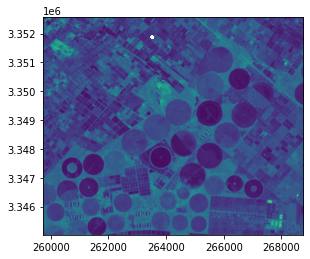

<AxesSubplot:>

In [3]:
b2_r = Raster('data/tile_36RTU_b02_median.tif')
b2_r.plot_show()

In [ ]:
import 

In [4]:
def segmentation(raster:Union[Raster, np.ndarray, str],
                 profile: Optional[rasterio.profiles.Profile]=None,
                 crs: Optional[pyproj.crs.crs.CRS]=None,
                 out_path:str=None,
                 tmp_vrt_path: str=None,
                 seg_mode:str='vector',
                 seg_filter:str='meanshift',
                 ms_spatialr:int=5,
                 ms_ranger:float=15.0,
                 ms_thres:float=0.1,
                 ms_maxiter:int=100,
                 ms_minsize:int=100,
                 cc_expr:Optional[str]=None,
                 ws_thres: float=0.01,
                 ws_level: float=0.1,
                 mp_size: int=5,
                 mp_start:int=1,
                 mp_step:int=1,
                 mp_sigma:float=1.0,
                 v_inmask:Optional[Union[Raster, np.ndarray, str]]=None,
                 # v_eight_neighbor:bool = False,
                 # v_stitch: bool =True,
                 v_minsize:int = 1,
                 v_simplify: float = 0.1,
                 v_layername: str = 'layer',
                 v_fieldname: str = 'DN',
                 v_tilesize: int = 1024,
                 v_startlabel: int = 1,
                 v_outmode: str = 'ovw'
                 # v_ogroptions: Optional[str] = None
                 ) -> Optional[Raster]:
    """
    https://www.orfeo-toolbox.org/CookBook/Applications/app_Segmentation.html#mean-shift-options
    
    Args:
        raster:
            Input raster data. Path/list of paths to geotiff, Raster, or 2D np.ndarray.
            seg_mode='vector' support only geotiff.
        profile:
            Requied when raster is numpy.ndarray or Raster, and seg_mode='raster'. 
        crs:
            Requied when raster is numpy.ndarray or Raster, and seg_mode='vector'. 
        out_path:
            Required when seg_mode='vector', and optional when seg_mode='raster'.
        seg_mode:
             Choice of processing mode. Choices are "vector" or "raster".
        seg_filter:
            Type of filter to use for segmentation. Choices are "meanshift",
            "cc", "watershed", or "mprofiles".
    """
    # validation
    from_geotiff = False
    if isinstance(raster, str):
        from_geotiff = True
    if isinstance(raster, list) and isinstance(raster[0], str):
        from_geotiff = True
        if tmp_vrt_path is None:
            raise ValueError('tmp_vrt_path is requierd for multiband raster as input')
    if (seg_mode == 'vector') and (not from_geotiff):
        raise ValueError('vector mode support only geotiff input.')
    if (seg_mode == 'vector') and (out_path is None):
        raise ValueError(f'out_path is requied in vector mode.')
    if isinstance(raster, np.ndarray):
        if (seg_mode == 'vector') and (crs is None):
            raise ValueError('crs is required in vector mode with np.ndarray as input.')
        if (seg_mode == 'raster') and (profile is None):
            raise ValueError('profile is required in raster mode with np.ndarray as input.')
    
    app = otb.Registry.CreateApplication('Segmentation')
    
    if from_geotiff == True:
        if isinstance(raster, str):
            with rasterio.open(raster) as src:
                profile = src.profile
            app.SetParameterString('in', raster)
        elif isinstance(raster, list):
            with rasterio.open(raster[0]) as src:
                profile = src.profile
                
            # Generating VRT for band rasters
            gdal.BuildVRT(tmp_vrt_path, raster,
                          options=gdal.BuildVRTOptions(
                              gdal.ParseCommandLine('-separate')))
            app.SetParameterString('in', tmp_vrt_path)
            
    if isinstance(raster, np.ndarray):
        app.SetImageFromNumpyArray('in', raster)
        
    if isinstance(raster, Raster):
        app.SetImageFromNumpyArray('in', raster.array[0])
        profile = raster.profile
        crs = raster.profile['crs']

    app.SetParameterString('mode', seg_mode)
    app.SetParameterString('filter', seg_filter)
    
    if seg_filter == 'meanshift':
        app.SetParameterInt('filter.meanshift.spatialr', ms_spatialr)
        app.SetParameterFloat('filter.meanshift.ranger', ms_ranger)
        app.SetParameterFloat('filter.meanshift.thres', ms_thres)
        app.SetParameterInt('filter.meanshift.maxiter', ms_maxiter)
        app.SetParameterInt('filter.meanshift.minsize', ms_minsize)
    elif seg_filter == 'cc':
        app.SetParameterString('filter.cc.expr', cc_expr)
    elif seg_filter == 'watershed':
        app.SetParameterFloat('filter.watershed.threshold', ws_thres)
        app.SetParameterFloat('filter.watershed.level', ws_level)
    elif seg_filter == 'mprofiles':
        app.SetParameterInt('filter.mprofiles.size', mp_size)
        app.SetParameterInt('filter.mprofiles.start', mp_start)
        app.SetParameterInt('filter.mprofiles.step', mp_step)
        app.SetParameterFloat('filter.mprofiles.sigma', mp_sigma)
    else:
        raise ValueError(f'seg_filter: {seg_filter} is not supported')
        
    if seg_mode == 'vector':
        if v_inmask is None:
            pass
        elif isinstance(v_inmask, str):
            app.SetParameterString('mode.vector.inmask', v_inmask)
        elif isinstance(v_inmask, np.ndarray):
            app.SetImageFromNumpyArray('mode.vector.inmask', v_inmask)
        elif isinstance(v_inmask, Raster):
            app.SetImageFromNumpyArray('mode.vector.inmask', v_inmask.array[0])
        else:
            raise TypeError(f'v_inmask type {type(v_inmask)} is not supported.')
        # app.SetParameterString('mode.vector.neighbor', v_eight_neighbor)
        # app.SetParameterString('mode.vector.stitch', v_stitch)
        app.SetParameterInt('mode.vector.minsize', v_minsize)
        app.SetParameterFloat('mode.vector.simplify', v_simplify)
        app.SetParameterString('mode.vector.layername', v_layername)
        app.SetParameterString('mode.vector.fieldname', v_fieldname)
        app.SetParameterInt('mode.vector.tilesize', v_tilesize)
        app.SetParameterInt('mode.vector.startlabel', v_startlabel)
        app.SetParameterString('mode.vector.outmode', v_outmode)
        # app.SetParameterString('mode.vector.ogroptions', v_ogroptions)
        
    if out_path is not None:
        app.SetParameterString(f'mode.{seg_mode}.out', out_path)
        app.ExecuteAndWriteOutput()
        filename, file_extension = os.path.splitext(out_path)
        if not from_geotiff:
            if file_extension == '.shp':
                # add prj file
                with open(filename + '.prj', 'w') as prj:
                    prj.write(crs.to_wkt(WktVersion.WKT1_ESRI))
            elif file_extension == '.tif':
                # append metadata to tiff
                with rasterio.open(out_path, 'r+') as src:
                    for key in profile:
                        if key in ['width', 'height', 'count']:
                            continue
                        setattr(src, key, profile[key])
    else:
        app.Execute()
    
    if seg_mode == 'raster':
        app_output = app.GetImageAsNumpyArray('mode.raster.out')
        return Raster(array=app_output, profile=profile)
    else:
        return None

## Segmentation tiff file

### Vector mode 

In [5]:
out = segmentation(raster='data/tile_36RTU_b02_median.tif',
                   seg_mode='vector',
                   ms_spatialr = 5,
                   ms_ranger=10,
                   out_path='data/seg_from_tiff.shp')
print(out)

2020-12-10 15:24:02 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:02 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:02 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:03 (WARNING) Segmentation: The input image has no data values but this application does not handle no-data. No-data pixels will be treated as regular pixels.
2020-12-10 15:24:03 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:03 (INFO) Segmentation: Simplify the geometry.
2020-12-10 15:24:03 (INFO) Segmentation: Large scale segmentation mode which output vector data
2020-12-10 15:24:03 (INFO): Estimation will be performed in 2 blocks of 832x754 pixels
Computing meanshift segmentation: 100% [**************************************************] (8s)
2020-12-10 15:24:11 (INFO) Segmentation: Stream size: [832, 754]
2020-12-10 15:24:11 (INFO) Segmentation: Segmentation done, stiching polygons ...
Stitching polygons: 100% [*****

In [6]:
# multiband
out = segmentation(raster=['data/tile_36RTU_b02_median.tif', 'data/tile_36RTU_b03_median.tif', 'data/tile_36RTU_b04_median.tif'],
                   seg_mode='vector',
                   tmp_vrt_path='data/tmp.vrt',
                   ms_spatialr = 5,
                   ms_ranger=10,
                   out_path='data/seg_from_tiffs.shp')
print(out)

2020-12-10 15:24:11 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:11 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:11 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:11 (WARNING) Segmentation: The input image has no data values but this application does not handle no-data. No-data pixels will be treated as regular pixels.
2020-12-10 15:24:11 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:11 (INFO) Segmentation: Simplify the geometry.
2020-12-10 15:24:11 (INFO) Segmentation: Large scale segmentation mode which output vector data
2020-12-10 15:24:11 (INFO): Estimation will be performed in 2 blocks of 832x754 pixels
Computing meanshift segmentation: 100% [**************************************************] (6s)
2020-12-10 15:24:18 (INFO) Segmentation: Stream size: [832, 754]
2020-12-10 15:24:18 (INFO) Segmentation: Segmentation done, stiching polygons ...
Stitching polygons: 100% [*****

### Raster mode

In [7]:
out = segmentation(raster='data/tile_36RTU_b02_median.tif',
                   seg_mode='raster',
                   ms_spatialr = 5,
                   ms_ranger=10,
                   out_path='data/seg_from_tiff.tif')
print(out)

2020-12-10 15:24:18 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:18 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:18 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:18 (WARNING) Segmentation: The input image has no data values but this application does not handle no-data. No-data pixels will be treated as regular pixels.
2020-12-10 15:24:18 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:18 (INFO) Segmentation: Segmentation mode which output label image.
2020-12-10 15:24:26 (INFO): Estimated memory for full processing: 12.9626MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2020-12-10 15:24:26 (INFO): File data/seg_from_tiff.tif will be written in 1 blocks of 904x754 pixels
Writing data/seg_from_tiff.tif...: 100% [**************************************************] (0s)
[[[   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   5

In [8]:
# multiband
out = segmentation(raster=['data/tile_36RTU_b02_median.tif', 'data/tile_36RTU_b03_median.tif', 'data/tile_36RTU_b04_median.tif'],
                   seg_mode='raster',
                   tmp_vrt_path='data/tmp.vrt',
                   ms_spatialr = 5,
                   ms_ranger=10,
                   out_path='data/seg_from_tiffs.tif')
print(out)

2020-12-10 15:24:26 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:26 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:26 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:26 (WARNING) Segmentation: The input image has no data values but this application does not handle no-data. No-data pixels will be treated as regular pixels.
2020-12-10 15:24:26 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:26 (INFO) Segmentation: Segmentation mode which output label image.
2020-12-10 15:24:31 (INFO): Estimated memory for full processing: 12.9626MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2020-12-10 15:24:31 (INFO): File data/seg_from_tiffs.tif will be written in 1 blocks of 904x754 pixels
Writing data/seg_from_tiffs.tif...: 100% [**************************************************] (0s)
[[[   1    1    1 ...   62   62   62]
  [   1    1    1 ...   62   62   62]
  [   1    1    1 ...   62  

## Segmentation numpy array

### Vector mode
not supported.

### Raster mode

In [9]:
out = segmentation(raster=b2_r.array[0],
                   seg_mode='raster',
                   ms_spatialr = 5,
                   profile=b2_r.profile,
                   ms_ranger=10,
                   out_path='data/seg_from_array.tif')
print(out)

2020-12-10 15:24:31 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:31 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:31 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:31 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:31 (INFO) Segmentation: Segmentation mode which output label image.
2020-12-10 15:24:39 (INFO): Estimated memory for full processing: 12.9626MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2020-12-10 15:24:39 (INFO): File data/seg_from_array.tif will be written in 1 blocks of 904x754 pixels
Writing data/seg_from_array.tif...: 100% [**************************************************] (0s)
[[[   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   53   53]
  ...
  [9137 9137 9137 ... 9150 9150 9150]
  [9137 9137 9137 ... 9150 9150 9150]
  [9137 9137 9137 ... 9150 9150 9578]]]
{'driver': 'GTiff', 'dtype': 'uint16', 'nod

## Segmentation Raster object

### Vector mode
not supported

### Raster mode

In [10]:
out = segmentation(raster=b2_r,
                   seg_mode='raster',
                   ms_spatialr = 5,
                   ms_ranger=10,
                   out_path='data/seg_from_raster.tif')
print(out)

2020-12-10 15:24:39 (INFO) Segmentation: Default RAM limit for OTB is 256 MB
2020-12-10 15:24:39 (INFO) Segmentation: GDAL maximum cache size is 796 MB
2020-12-10 15:24:39 (INFO) Segmentation: OTB will use at most 8 threads
2020-12-10 15:24:39 (INFO) Segmentation: Use threaded Mean-shift segmentation.
2020-12-10 15:24:39 (INFO) Segmentation: Segmentation mode which output label image.
2020-12-10 15:24:47 (INFO): Estimated memory for full processing: 12.9626MB (avail.: 256 MB), optimal image partitioning: 1 blocks
2020-12-10 15:24:47 (INFO): File data/seg_from_raster.tif will be written in 1 blocks of 904x754 pixels
Writing data/seg_from_raster.tif...: 100% [**************************************************] (0s)
[[[   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   53   53]
  [   1    1    1 ...   53   53   53]
  ...
  [9137 9137 9137 ... 9150 9150 9150]
  [9137 9137 9137 ... 9150 9150 9150]
  [9137 9137 9137 ... 9150 9150 9578]]]
{'driver': 'GTiff', 'dtype': 'uint16', 'n